In [14]:
using OptimalControl

## Direct solve

In [15]:
# problem

# parameters
const Cd = 310
const Tmax = 3.5
const β = 500
const b = 2
const t0 = 0
r0 = 1
v0 = 0
vmax = 0.1
m0 = 1
mf = 0.6
x0 = [ r0, v0, m0 ]

# model
ocp = Model()

time!(ocp, :initial, t0) # if not provided, final time is free
state!(ocp, 3, labels=["r", "v", "m"]) # state dim
control!(ocp, 1) # control dim

constraint!(ocp, :initial, x0)
constraint!(ocp, :control, u -> u, 0, 1) # constraints can be labeled or not
constraint!(ocp, :mixed, (x, u) -> x[1], r0, Inf,  :eq1)
constraint!(ocp, :mixed, (x, u) -> x[2], 0, vmax,  :eq2)
constraint!(ocp, :mixed, (x, u) -> x[3], mf, m0,   :eq3)

objective!(ocp, :mayer,  (t0, x0, tf, xf) -> xf[1], :max)

function F0(x)
    r, v, m = x
    D = Cd * v^2 * exp(-β*(r - 1))
    F = [ v, -D/m - 1/r^2, 0 ]
    return F
end

function F1(x)
    r, v, m = x
    F = [ 0, Tmax/m, -b*Tmax ]
    return F
end

f(x, u) = F0(x) + u*F1(x)

constraint!(ocp, :dynamics, f)

(::DynamicsFunction{:autonomous, :scalar}) (generic function with 3 methods)

In [16]:
# solve
direct_sol = solve(ocp)


Method = (:direct, :ADNLProblem, :ipopt)


This is Ipopt version 3.14.4, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:     1903
Number of nonzeros in inequality constraint Jacobian.:      404
Number of nonzeros in Lagrangian Hessian.............:    82215

Total number of variables............................:      405
                     variables with only lower bounds:        1
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      303
Total number of inequality constraints...............:      404
        inequality constraints with only lower bounds:      101
   inequality constraints with lower and upper bounds:      303
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.1000000e+00 1.10e+00 2.64e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00  

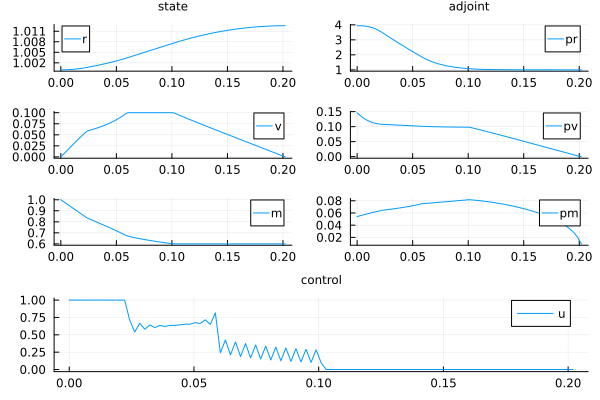

In [18]:
# plot solution
plot(direct_sol, size=(900, 900))

## Indirect solve

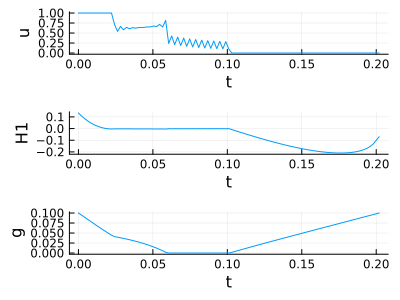

Initial guess:
[3.9420914449794613, 0.14627141257986345, 0.054117861481595975, 0.018178505231315752, 0.06059501743771918, 0.07473385483985366, 0.20198339145906394]


Iter     f(x) inf-norm    Step 2-norm      Step time
------   --------------   --------------   --------------


     1     3.242782e+00     0.000000e+00         5.699135
     2     5.354136e-01     1.989176e-02         0.782072


     3     5.253659e-01     2.951305e-03         0.038056
     4     1.657525e-01     2.082196e-03         0.162409


     5     1.608547e-01     2.563355e-03         0.049889
     6     3.164634e-02     4.972940e-03         0.055208


     7     2.245019e-02     1.100058e-04         0.049731
     8     2.645546e-01     1.224861e-02         0.047216


     9     1.342166e-03     1.484164e-02         0.129304
    10     5.538875e-04     1.920810e-07         0.040224
    11     1.410843e-04     1.148155e-08         0.041285
    12     1.089101e-04     2.490535e-10         0.041964


    13     2.124134e-04     1.092683e-09         0.144124
    14     1.952443e-05     4.948375e-09         0.043800
    15     1.235029e-06     4.357955e-11         0.041047
    16     1.146271e-06     1.123111e-12         0.042440


    17     4.750333e-07     4.493293e-14         0.068396
    18     2.779023e-08     2.698655e-14         0.186068


    19     2.046278e-09     5.632314e-17         0.046586
Results of Nonlinear Solver Algorithm
 * Algorithm: Modified Powell
 * Starting Point: [3.9420914449794613, 0.14627141257986345, 0.054117861481595975, 0.018178505231315752, 0.06059501743771918, 0.07473385483985366, 0.20198339145906394]
 * Zero: [3.9457646591162034, 0.15039559628359686, 0.053712712969520515, 0.02350968402023801, 0.05973738095397227, 0.10157134841905507, 0.20204744057725113]
 * Inf-norm of residuals: 0.000000
 * Convergence: true
 * Message: algorithm estimates that the relative error between x and the solution is at most tol
 * Total time: 7.709087 seconds
 * Function Calls: 19
 * Jacobian Calls (df/dx): 1


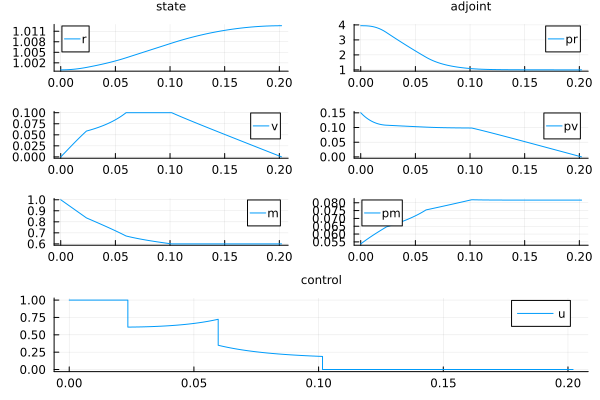

In [11]:
# shooting function

# bang controls
u0(x, p) = 0.
u1(x, p) = 1.

# singular control of order 1
H0(x, p) = p' * F0(x)
H1(x, p) = p' * F1(x)
H01 = Poisson(H0, H1)
H001 = Poisson(H0, H01)
H101 = Poisson(H1, H01)
us(x, p) = -H001(x, p) / H101(x, p)

# boundary control
remove_constraint!(ocp, :eq1)
remove_constraint!(ocp, :eq3)
constraint!(ocp, :boundary, (t0, x0, tf, xf) -> xf[3], mf, :eq4) # one value => equality (not boxed inequality); changed to equality constraint for shooting
#
g(x) = constraint(ocp, :eq2, :upper)(x, 0) # g(x, u) ≥ 0 (cf. nonnegative multiplier)
ub(x, _) = -Ad(F0, g)(x) / Ad(F1, g)(x)
μb(x, p) = H01(x, p) / Ad(F1, g)(x)

# associated flows
f0 = Flow(ocp, u0)
f1 = Flow(ocp, u1)
fs = Flow(ocp, us)
fb = Flow(ocp, ub, (x, _) -> g(x), μb)

# shooting function
function shoot!(s, p0, t1, t2, t3, tf) # B+ S C B0 structure

    x1, p1 = f1(t0, x0, p0, t1)
    x2, p2 = fs(t1, x1, p1, t2)
    x3, p3 = fb(t2, x2, p2, t3)
    xf, pf = f0(t3, x3, p3, tf)
    s[1] = constraint(ocp, :eq4)(t0, x0, tf, xf)
    s[2:3] = pf[1:2] - [ 1, 0 ]
    s[4] = H1(x1, p1)
    s[5] = H01(x1, p1)
    s[6] = g(x2)
    s[7] = H0(xf, pf) # free tf

end

In [ ]:
# Initialisation from direct solution
t = direct_sol.times
x = direct_sol.state
u = direct_sol.control
p = direct_sol.adjoint
H1(t) = H1(x(t), p(t))

u_plot = plot(t, t -> u(t)[1], xlabel = "t", ylabel = "u", legend = false)
H1_plot = plot(t, H1, xlabel = "t", ylabel = "H1", legend = false)
g_plot = plot(t, g∘x, xlabel = "t", ylabel = "g", legend = false)
display(plot(u_plot, H1_plot, g_plot, layout=(3,1), size=(400,300)))

η = 1e-3
t13 = t[ abs.(H1.(t)) .≤ η ]
t23 = t[ 0 .≤ (g∘x).(t) .≤ η ]
p0 = p(t0)
t1 = min(t13...)
t2 = min(t23...)
t3 = max(t23...)
tf = t[end]
ξ = [ p0 ; t1 ; t2 ; t3 ; tf ]

println("Initial guess:\n", ξ)

In [ ]:
# solve the shooting equation
using MINPACK
nle = (s, ξ) -> shoot!(s, ξ[1:3], ξ[4], ξ[5], ξ[6], ξ[7])
indirect_sol = fsolve(nle, ξ, show_trace=true)
println(indirect_sol)

In [ ]:
# plot the solution
p0 = indirect_sol.x[1:3]
t1 = indirect_sol.x[4]
t2 = indirect_sol.x[5]
t3 = indirect_sol.x[6]
tf = indirect_sol.x[7]

f1sb0 = f1 * (t1, fs) * (t2, fb) * (t3, f0) # concatenation of the Hamiltonian flows
flow_sol = f1sb0((t0, tf), x0, p0)

plot(flow_sol, size=(900, 900))